In [64]:
import os

import torch

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_theme()

from source.constants import RESULTS_PATH, PLOTS_PATH
from source.utils.uncertainty_measures import calculate_uncertainties
from source.utils.metrics import auroc, aupr, fpr_at_tpr_x

os.makedirs(PLOTS_PATH, exist_ok=True)

In [65]:
seed = 42

methods = ["deep_ensemble", "laplace", "mc_dropout"]
dataset_names = ["cifar10", "cifar100", "svhn", "tin"]
adv_atks = ["fgsm", "linfpgd"] 
n_classes = [10, 100, 10, 200]
models = ["resnet18", "densenet169"]

method = methods[0]                         # select method 
metric = [auroc, aupr, fpr_at_tpr_x][0]     # select metric
adv_atk = adv_atks[0]                       # select adversarial attack

allow_flip = False                           # allow flipping of label for AUROC

p_drop = 0.2                                # dropout rate of MC dropout     

model = models[0]                           # select model
runs = 5                                    # number of runs

print(adv_atk, method, model, metric.__name__)

fgsm deep_ensemble resnet18 auroc


In [66]:
probits = list()
y_tests = list()

for dataset_name, n_class in zip(dataset_names, n_classes):

    if method == "deep_ensemble":
        path = os.path.join(RESULTS_PATH, f"{dataset_name}_{model}_seed{seed}")
    elif method == "laplace":
        path = os.path.join(RESULTS_PATH, f"{dataset_name}_{model}_seed{seed}_laplace")
    elif method == "mc_dropout":
        path = os.path.join(RESULTS_PATH, f"{dataset_name}_{model}_dropout{p_drop}_seed{seed}")

    p = torch.load(os.path.join(path, f"{dataset_name}_probits.pt")).to(torch.float32)
    p = p.reshape(len(p), runs, -1, n_class)
    y_test = torch.load(os.path.join(path, f"{dataset_name}_ys.pt"))
    y_tests.append(y_test)
    probits.append(p)
    print(probits[-1].shape)

uncertainties = list()

for d, ds_probits in enumerate(probits):
    # reversed_probits = torch.flip(ds_probits, [2])
    uncertainties.append(calculate_uncertainties(ds_probits, ds_probits))

### Adversarial examples

ae_probits = list()

for dataset_name, n_class in zip(dataset_names, n_classes):

    if method == "deep_ensemble":
        path = os.path.join(RESULTS_PATH, f"{dataset_name}_{model}_seed{seed}")
    elif method == "laplace":
        path = os.path.join(RESULTS_PATH, f"{dataset_name}_{model}_seed{seed}_laplace")
    elif method == "mc_dropout":
        path = os.path.join(RESULTS_PATH, f"{dataset_name}_{model}_dropout{p_drop}_seed{seed}")

    ae_path = os.path.join(path, "adversarial_examples")
    p = torch.load(os.path.join(ae_path, f"{adv_atk}_probits.pt")).to(torch.float32)
    p = p.reshape(len(p), runs, -1, n_class)
    ae_probits.append(p)
    print(ae_probits[-1].shape)

ae_uncertainties = list()

for d, ds_probits in enumerate(ae_probits):
    # reversed_probits = torch.flip(ds_probits, [2])
    ae_uncertainties.append(calculate_uncertainties(ds_probits, ds_probits))

torch.Size([10000, 5, 10, 10])
torch.Size([10000, 5, 10, 100])
torch.Size([26032, 5, 10, 10])
torch.Size([10000, 5, 10, 200])
torch.Size([10000, 5, 10, 10])
torch.Size([10000, 5, 10, 100])
torch.Size([26032, 5, 10, 10])
torch.Size([10000, 5, 10, 200])


In [67]:
unc_names = ["A1", "A2", "A3", "B1", "B2", "B3", "C1", "C2", "C3"]
components = ["TU", "AU", "EU"]

verbose = False

all_perfs = list()

for i in range(len(dataset_names)):
    for c, comp in enumerate(components):
        for measure in unc_names:
            if comp == "EU" and measure == "B2":
                continue # B2 is not defined for epistemic uncertainty
            scores_clean = uncertainties[i][measure][c]
            scores_adv = ae_uncertainties[i][measure][c]

            fraction = list()

            for r in range(runs):
                
                # mask where clean predictions of attacked model are correct
                mask = torch.argmax(probits[i][:, r, 0], dim=-1) == y_tests[i]
                if verbose and c == 0 and measure == "A1": print(dataset_names[i], ", Correctness:", mask.float().mean())
                # mask where adversarial predictions of attacked model are incorrect
                mask_adv = torch.argmax(ae_probits[i][:, r, 0], dim=-1) != y_tests[i]
                if verbose and c == 0 and measure == "A1": print(dataset_names[i], ", Attack Success:", mask_adv.float().mean())
                # mask where clean predictions of attacked model are correct and adversarial predictions are incorrect
                mask = mask & mask_adv
                if verbose and c == 0 and measure == "A1": print(dataset_names[i], ", Subset:", mask.float().mean())

                fraction.append(f"{mask.float().mean().item() * 100:.2f}%")

                scores_clean_ = scores_clean[mask, r]
                scores_adv_ = scores_adv[mask, r] 

                scores = torch.cat([scores_clean_, scores_adv_])
                ys = torch.cat([torch.zeros(size=(len(scores_clean_), ), dtype=torch.long), 
                                torch.ones(size=(len(scores_adv_), ), dtype=torch.long)])
                
                # flip labels if clean model is more uncertain than attacked model
                if allow_flip and scores_clean.mean() > scores_adv.mean():
                    ys = 1 - ys

                all_perfs.append(metric(scores, ys).item() * 100)
            
            if c==0 and measure == "A1":
                print(dataset_names[i], fraction)

all_perfs = torch.tensor(all_perfs).reshape(len(dataset_names), -1, runs)
print(all_perfs.shape)

cifar10 ['58.77%', '60.59%', '60.01%', '60.21%', '62.22%']
cifar100 ['67.51%', '68.21%', '67.13%', '67.28%', '67.65%']
svhn ['42.14%', '39.01%', '40.57%', '41.55%', '42.31%']
tin ['52.97%', '52.55%', '52.73%', '53.39%', '52.35%']
torch.Size([4, 26, 5])


In [68]:
def plot(data, title, name:str = None):

    tu_colors = ["#8FB4EF", "#5D8CD8", "#4C72B0", "#F2AD85", "#DD8452", "#CC6333"]
    au_colors = ["#5D8CD8", "#DD8452", "#55A868"]
    eu_colors = ["#8FB4EF", "#5D8CD8", "#4C72B0", "#F2AD85", "#CC6333", "#85BF91", "#55A868", "#418050"]

    # tu_colors = au_colors = eu_colors = sns.color_palette("deep")


    tu_labels = ["A1", "A2", "A3", "B/C1", "B/C2", "B/C3"]
    au_labels = ["A", "B", "C"]
    eu_labels = ["A1", "A2", "A3", "B1", "B3", "C1", "C2", "C3"]

    # Create a figure
    fig, axs = plt.figure(figsize=(8, 3.2)), list()

    # Create a GridSpec with 1 row and 3 columns, and specify relative widths
    gs = gridspec.GridSpec(1, 3, width_ratios=[6.25, 3.25, 8.25])

    # Create subplots in the specified grid locations
    axs.append(fig.add_subplot(gs[0]))
    axs.append(fig.add_subplot(gs[1], sharey=axs[-1]))
    axs.append(fig.add_subplot(gs[2], sharey=axs[-1]))

    for i in range(len(tu_labels)):
        b = axs[0].bar(tu_labels[i], data[i].mean(), yerr=data[i].std(), color=tu_colors[i], label=tu_labels[i], linewidth=0)
        # if i >= 3:
        #     axs[0].bar(i + b[0].get_width() / 4, data[i].mean(), color=eu_colors[2 + i], linewidth=0, width=b[0].get_width() / 2)
    axs[0].set_xlabel("TU")

    for i in range(len(au_labels)):
        tl = 9
        axs[1].bar(au_labels[i], data[tl + i * 3].mean(), yerr=data[tl + i * 3].std(), color=au_colors[i], label=au_labels[i], linewidth=0)
    axs[1].set_xlabel("AU")

    for i in range(len(eu_labels)):
        tl = 18
        axs[2].bar(eu_labels[i], data[tl + i].mean(), yerr=data[tl + i].std(), color=eu_colors[i], label=eu_labels[i], linewidth=0)
    axs[2].set_xlabel("EU")

    # set ylim to minimum and maximum values
    for i in range(3):
        axs[i].hlines(data.mean(dim=-1).min() if metric == fpr_at_tpr_x else data.mean(dim=-1).max(), 
                      -0.625, len([tu_labels, au_labels, eu_labels][i]) - 0.375, colors="black", linestyles="dashed", alpha=0.3)
    
    data_range = (data.mean(dim=-1) + data.std(dim=-1)).max().item() - (data.mean(dim=-1) - data.std(dim=-1)).min().item()
    plt.ylim([(data.mean(dim=-1) - data.std(dim=-1)).min().item() - data_range * 0.05, 
              (data.mean(dim=-1) + data.std(dim=-1)).max().item() + data_range * 0.05])
    axs[0].set_ylabel({auroc: "AUROC", aupr: "AUPR", fpr_at_tpr_x: "FPR95"}[metric])
    axs[1].set_title(title, fontsize=14)

    # Optionally, hide y-axis labels for all but the first plot
    plt.setp(axs[1].get_yticklabels(), visible=False)
    plt.setp(axs[2].get_yticklabels(), visible=False)

    for ax, n_data in zip(axs, [len(tu_labels), len(au_labels), len(eu_labels)]):
        ax.set_xlim(-0.625, n_data - 0.375)

    plt.tight_layout()
    plt.show()
    if name is not None:
        fig.savefig(os.path.join(PLOTS_PATH, f"{name}.pdf"))


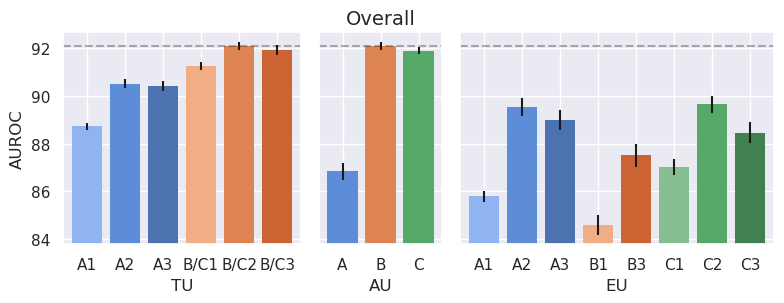

In [69]:
plt_data = torch.mean(all_perfs, dim=0)

plot(plt_data, "Overall", f"ae_{method}_{model}_{adv_atk}_{metric.__name__}_flip{allow_flip}_overall")

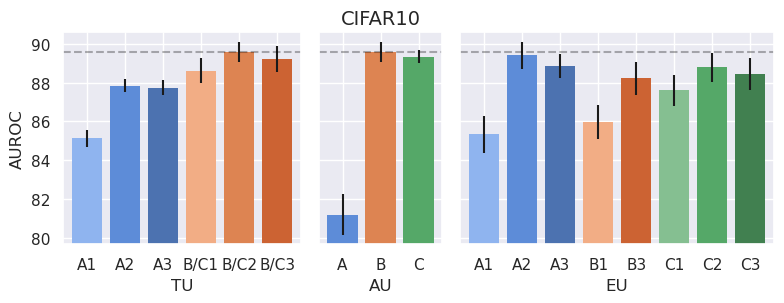

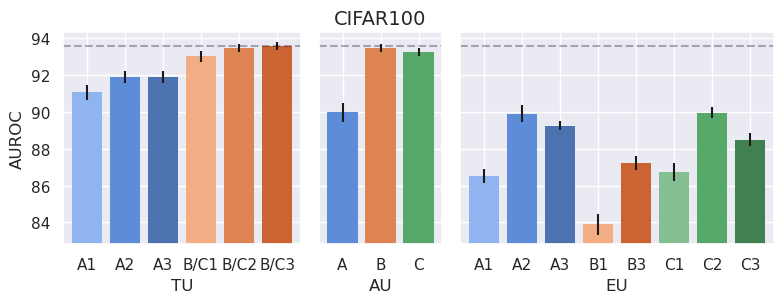

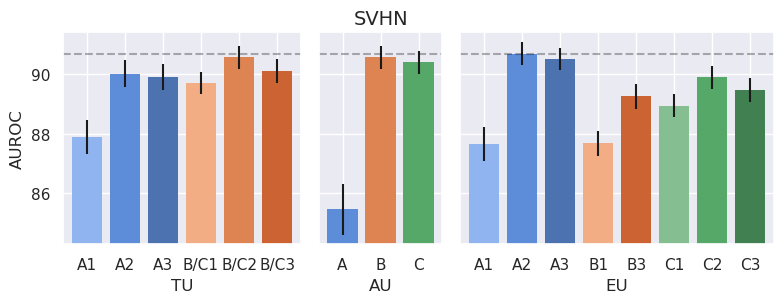

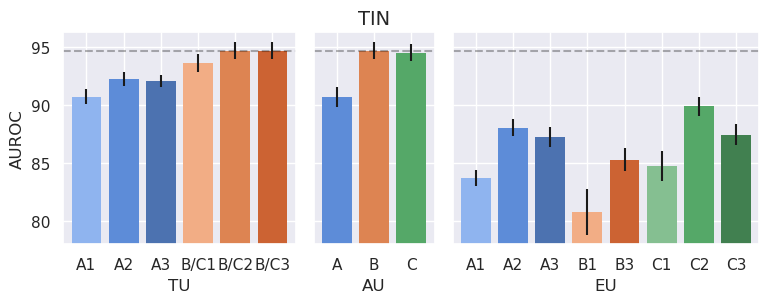

In [70]:
for i in range(len(dataset_names)):
    plot(all_perfs[i], f"{dataset_names[i].upper()}")#, f"{method}_{model}_{adv_atk}_{metric.__name__}_{dataset_names[i]}")